### Load Train Dataset

In [5]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)
def preprocessing(lr, hr):
    hr = tf.cast(hr, tf.float32) /255.
        
    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr_patch = tf.image.random_crop(hr, size=[96,96,3])
        
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄입니다
    # 이렇게 만든 저해상도 이미지를 SRGAN의 입력으로 사용합니다.
    lr_patch = tf.image.resize(hr_patch, [96//4, 96//4], "bicubic")
    return lr_patch, hr_patch

train = train.map(preprocessing).shuffle(buffer_size=10).batch(8)
valid = valid.map(preprocessing).batch(8)
print("✅")

2022-09-21 13:08:37.051965: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-21 13:08:38.308413: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22308 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:a1:00.0, compute capability: 8.6


✅


### Define SR Model

In [6]:
from tensorflow.keras import Input, Model, layers

# 그림의 파란색 블록을 정의합니다.
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])

# 그림의 뒤쪽 연두색 블록을 정의합니다.
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    # 그림의 PixelShuffler 라고 쓰여진 부분을 아래와 같이 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)
    
# 전체 Generator를 정의합니다.
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)
    
    for _ in range(5):
        out = gene_base_block(out)
    
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])
    
    for _ in range(2):
        out = upsample_block(out)
        
    out = layers.Conv2D(3, 9, 1, "same", activation="tanh")(out)
    return Model(inputs, out)

print("✅")

✅


In [7]:
# 그림의 파란색 블록을 정의합니다.
def disc_base_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

# 전체 Discriminator 정의합니다.
def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    
    for n_filters in [128, 256, 512]:
        out = disc_base_block(out, n_filters)
    
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)

print("✅")

✅


### Initialize model and optimizer

In [10]:
from tensorflow.keras import losses, metrics, optimizers

generator = get_generator()
discriminator = get_discriminator()

# 사용할 loss function 및 optimizer 를 정의합니다.
bce = losses.BinaryCrossentropy(from_logits=False)
mse = losses.MeanSquaredError()
gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)

### Define Train Step

In [ ]:
def get_gene_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

def get_disc_loss(real_out, fake_out):
    return bce(tf.ones_like(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)

@tf.function
def get_content_loss(hr_real, hr_fake):
    return mse(hr_real, hr_fake)

@tf.function
def step(lr, hr_real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        hr_fake = generator(lr, training=True)
        
        real_out = discriminator(hr_real, training=True)
        fake_out = discriminator(hr_fake, training=True)
        
        perceptual_loss = get_content_loss(hr_real, hr_fake) + 1e-3 * get_gene_loss(fake_out)
        discriminator_loss = get_disc_loss(real_out, fake_out)
        
    gene_gradient = gene_tape.gradient(perceptual_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return perceptual_loss, discriminator_loss


### Train

In [16]:
from IPython import display

gene_losses = metrics.Mean()
disc_losses = metrics.Mean()

epoch = 0
while True:
    epoch += 1
    display.clear_output()
    generator.save('saved_model/srgan_g.h5')
    discriminator.save('saved_model/srgan_d.h5')
    
    for i, (lr, hr) in enumerate(train):
        g_loss, d_loss = step(lr, hr)
        
        gene_losses.update_state(g_loss)
        disc_losses.update_state(d_loss)
        
        # 10회 반복마다 loss를 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \nGenerator_loss:{gene_losses.result():.4f} \nDiscriminator_loss:{disc_losses.result():.4f}", end="\n\n")
             
    gene_losses.reset_states()
    disc_losses.reset_states()

EPOCH[65] - STEP[10] 
Generator_loss:0.0056 
Discriminator_loss:1.2002




KeyboardInterrupt



### Test

In [ ]:
generator = tf.keras.models.load_model('saved_model/srgan_g.h5')

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = generator.predict(image/255)
    sr = sr * 255
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

_, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train", "validation"],
    as_supervised=True
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

srgan_hr = apply_srgan(lr)
print("✅")

1/1 [==============================] - 2s 2s/step
✅


In [13]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

hr, lr = np.array(hr), np.array(lr)
bicubic_hr = cv2.resize(
    lr, 
    dsize=(hr.shape[1], hr.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

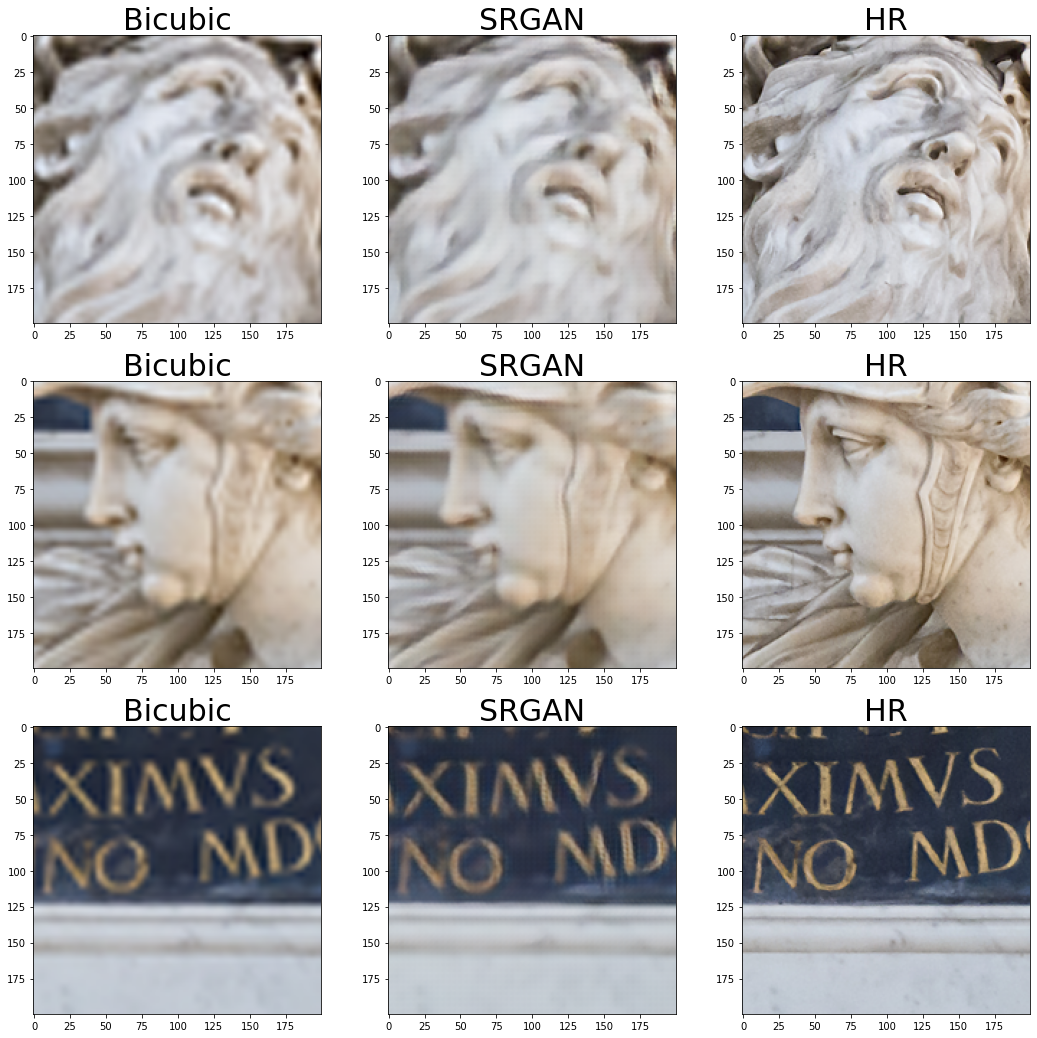

In [14]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(400,500), (300,1200), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

In [15]:
print('done')

done
